# Dealing with label noise in image classification

[Diego Ortego](https://sites.google.com/view/diegoortego/), [Insight Centre for Data Analytics](https://www.insight-centre.org/)

[Dublin City University](https://www.dcu.ie/)

---

This lab will illustrate the memorization of uniform random label noise when training CNNs for image classification. The lab will further introduce a combination of bootstrapping loss correction and mixup data augmentation to prevent memorization. Here, we will use the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) (50K images with 32x32 resolution) and will introduce label noise synthetically.

### Instructions

Anywhere you see a **???** in the code below, fill in in with the correct code.

In [ ]:
import sys
print(sys.version)

# Import packages
Find the PyTorch docs at https://pytorch.org/docs/stable/index.html

Tutorials: https://pytorch.org/tutorials/

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data as data
from torch import optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchvision.datasets.utils import download_file_from_google_drive


from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import time


In [ ]:
print('PyTorch version:', torch.__version__)
torch.cuda.get_device_properties(0).total_memory

# Hyperparameters + Enable GPU acceleration

In [ ]:
class configuration:
  def __init__(self):
    self.experiment_name = "LabelNoise_lab"
    self.num_classes = 10
    self.lr = 0.1 #learning rate
    self.M = [40, 70]
    self.batch_size = 100 #Training batch size
    self.test_batch_size = 100 #Test batch size
    self.epoch = 80
    self.epochBoot = 45 # Epoch to start bootstrapping loss correction
    self.train_root = "./data"
    self.download = False
    self.Mixup_Alpha = 1
    self.seed = 271828
    self.noise_ratio = 0.6 ## Noise level. Default, 60%.

In [ ]:
## Create arguments object
args = configuration()

In [ ]:
# Make sure to enable GPU acceleration!
device = 'cuda'

# Set random seed for reproducability
torch.backends.cudnn.deterministic = True  # fix the GPU to deterministic mode
torch.manual_seed(args.seed)  # CPU seed
torch.cuda.manual_seed_all(args.seed)  # GPU seed
random.seed(args.seed)  # python seed for image transformation
np.random.seed(args.seed)

# Define network architecture

In [ ]:
class SimpleCNN(nn.Module):
    
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        self.activation = nn.LeakyReLU(0.1)
        self.conv1a = nn.Conv2d(3, 128, 3, padding=1)
        self.bn1a = nn.BatchNorm2d(128)
        self.conv1b = nn.Conv2d(128, 128, 3, padding=1)
        self.bn1b = nn.BatchNorm2d(128)
        self.mp1 = nn.MaxPool2d(2, stride=2, padding=0)
        
        self.conv2a = nn.Conv2d(128, 256, 3, padding=1)
        self.bn2a = nn.BatchNorm2d(256)
        self.conv2b = nn.Conv2d(256, 256, 3, padding=1)
        self.bn2b = nn.BatchNorm2d(256)
        self.mp2 = nn.MaxPool2d(2, stride=2, padding=0)
        
        self.conv3a = nn.Conv2d(256, 512, 3, padding=0)
        self.bn3a = nn.BatchNorm2d(512)
        self.conv3b = nn.Conv2d(512, 128, 1, padding=0)
        self.bn3b = nn.BatchNorm2d(128)
        self.ap3 = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(128, num_classes)


    def forward(self, x, debug=False):
        x = self.activation(self.bn1a(self.conv1a(x)))
        x = self.activation(self.bn1b(self.conv1b(x)))
        x = self.mp1(x)
        
        x = self.activation(self.bn2a(self.conv2a(x)))
        x = self.activation(self.bn2b(self.conv2b(x)))
        x = self.mp2(x)
        
        x = self.activation(self.bn3a(self.conv3a(x)))
        x = self.activation(self.bn3b(self.conv3b(x)))
        x = self.ap3(x)

        x = x.view(-1, 128)

        return self.fc1(x)

# Create a custom dataset for CIFAR-10
PyTorch comes with a built-in dataset class for the CIFAR-10 dataset, but we need extra funcionalities to simulate label noise. The label noise type we will be using is a synthetic noise where labels are flipped uniformly at random to any other class with a pre-defined probability or noise ratio (self.noise_ratio). 
PyTorch also has built-in dataset classes for other common datasets and tasks like ImageNet. See: https://pytorch.org/docs/stable/torchvision/datasets.html

In [ ]:
class Cifar10Train(torchvision.datasets.CIFAR10):
    def __init__(self, args, train=True, transform=None, target_transform=None, download=False):
        super(Cifar10Train, self).__init__(args.train_root, train=train, transform=transform,
                                           target_transform=target_transform, download=download)

        self.args = args
        self.targets = np.asarray(self.targets)
        self.soft_labels = np.zeros((len(self.targets), 10), dtype=np.float32)
        self.original_labels = np.copy(self.targets)

        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # Training set or validation set

        self.num_classes = self.args.num_classes
        self.noisy_indexes = []
        self.clean_indexes = []
        self.clean_labels = []
        self.noisy_labels = []
        self.soft_labels = []
        self.labelsNoisyOriginal = []
        self._count = 1
        self.prediction = []

        # From in ou split function:
        self._num = int(len(self.targets) * self.args.noise_ratio)

    ################# Random in-distribution noise #########################
    def random_in_noise(self):

        # to be more equal, every category can be processed separately
        np.random.seed(self.args.seed)
        idxes = np.random.permutation(len(self.targets))
        clean_labels = np.copy(self.targets)
        noisy_indexes = idxes[0:self._num]
        clean_indexes = idxes[self._num:]
        for i in range(len(idxes)):
            if i < self._num:
                label_sym = np.random.randint(self.num_classes, dtype=np.int32)
                while (label_sym == self.targets[idxes[i]]):  # To exclude the original label
                    label_sym = np.random.randint(self.num_classes, dtype=np.int32)
                self.targets[idxes[i]] = label_sym

        self.targets = np.asarray(self.targets, dtype=np.long)
        self.noisy_labels = np.copy(self.targets)
        self.noisy_indexes = noisy_indexes
        self.clean_labels = clean_labels
        self.clean_indexes = clean_indexes


    def __getitem__(self, index):

        img, labels, clean_labels = self.data[index], self.targets[index], self.clean_labels[index]

        img = Image.fromarray(img)

        img_noDA = self.target_transform(img)

        img1 = self.transform(img)

        return img1, img_noDA, labels, index, clean_labels



#Standard training results: oracle visualization
First, download the provided data. Then, load loss curves of a standard training using a cross-entropy loss. Using an oracle to distinguish between clean and noisy samples, plot the median loss for each type.

In [ ]:
!pip install gdown

In [ ]:
!gdown --id 1qTnjdVOyE57WJdhEHAsO_iMGTCBkTUze
#!gdown --id 1MN3PW2-0v602DMrwvUI45WMeG-Iptoat


In [ ]:
!tar -vxf metrics_LabelNoise_lab.tar
!rm metrics_LabelNoise_lab.tar

In [ ]:
##Accuracy
res_path = "."
all_loss_train_epoch = np.load(res_path + '/' + 'losses_per_sample_train_CE.npy')
clean_idx = np.load(res_path + '/' + 'clean_idx.npy')
noisy_idx = np.load(res_path + '/' + 'noisy_idx.npy')

numEpochs = all_loss_train_epoch.shape[0]
epochs = range(numEpochs)

plt.figure(1)
plt.plot(epochs, np.median(all_loss_train_epoch[:, np.sort(clean_idx)], 1), label='Clean samples loss')
plt.plot(epochs, np.median(all_loss_train_epoch[:, np.sort(noisy_idx)], 1), label='Noisy samples loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

**QUESTION FOR STUDENTS**

Explain the loss behaviour. For noisy samples, why the behaviour is different compared to clean samples?

Answer (edit the cell):

# Training functions
Define a training loop that uses a label noise-robust loss function. In particular, we are going to add mixup data augmentation and bootstrapping loss correction. The loss is similar to that in Eq. 13 in the CVPR 2021 paper https://arxiv.org/abs/2012.04462, but using soft labels and the regularizations in Eq. 10 and 12 from https://arxiv.org/abs/1803.11364. The first regularization encourages a uniform prediction across classes in the mini-batch samples, while the second is an entropy minimization term for each sample, i.e a term that encourages spiky predictions.

In [ ]:
def reg_loss_class(mean_tab, num_classes):

    p = 1./num_classes
    loss = torch.sum(torch.log(p/mean_tab) * p)

    return loss

def train_mixup_boot(args, model, device, train_loader, optimizer, epoch, sample_loss_per_epoch_tensor):
    train_loss = []
    acc_per_batch = []

    # switch to train mode
    model.train()

    alpha = args.Mixup_Alpha

    counter = 1
    correct = 0
    criterionCE = torch.nn.CrossEntropyLoss()
    criterionCE2 = torch.nn.CrossEntropyLoss(reduction='none')

    for batch_idx, (imgs, imgsNoDA, labels, index, _) in enumerate(train_loader):

        images = imgs.to(device)
        imgsNoDA = imgsNoDA.to(device)
        labels = labels.to(device)

        batch_size = images.size()[0]

        ########################### Mixup ######################################
        ## Extra forward pass to get non-mixed predictions that are needed for labels
        optimizer.zero_grad()
        with torch.no_grad():
            output_noDA = model(imgsNoDA)
            # output_noDA.detach()

        optimizer.zero_grad()

        if alpha > 0:
            lam = np.random.beta(alpha, alpha)
        else:
            lam = 1

        index_mix = torch.randperm(batch_size).cuda()
        imagesMix = lam * images + (1 - lam) * images[index_mix, :]
        labels_1, labels_2 = labels, labels[index_mix]
        outputs = model(imagesMix)  ##Logits
        output_mean = F.softmax(outputs, dim=1)
        tab_mean_class = torch.mean(output_mean, -2)
        
        ########################################################################
        if epoch < args.epochBoot: ## Early training only uses mixup loss
            loss = lam*criterionCE(outputs, labels_1) + (1-lam)*criterionCE(outputs, labels_2)
        else:
            
            ##Soft bootstrapping
            prob = F.softmax(output_noDA, dim=1)
            z1 = prob.clone().detach()
            z2 = z1[index_mix, :]

            B = 0.2  # Static weight for perceptual term, i.e. always rely 20% on prediction and 80% on original label

            # First mixup term
            # a) Loss using original labels
            loss_x1 = lam * (1 - B) * criterionCE(outputs, labels_1)

            # b) Perceptual term using network prediction (data augmentation free)
            loss_x1_pred = torch.mean(lam * B * (-torch.sum(z1 * F.log_softmax(outputs, dim=1), dim=1)))


            # Second mixup term (permuted order affects here)
            # a) Loss using original labels
            loss_x2 = (1 - lam) * (1 - B) * criterionCE(outputs, labels_2)

            # b) Perceptual term using network prediction (data augmentation free)
            loss_x2_pred = torch.mean((1-lam) * B * (-torch.sum(z2 * F.log_softmax(outputs, dim=1), dim=1)))

            loss = loss_x1 + loss_x1_pred + loss_x2 + loss_x2_pred
            loss_reg = reg_loss_class(tab_mean_class, args.num_classes)
            loss_reg2 = -torch.mean(torch.sum(prob * F.log_softmax(outputs, dim=1), dim=1))

            ##Final loss: bootstrapping and regularization terms
            loss = loss + loss_reg + loss_reg2


        train_loss.append(loss.item())
        
        preds = outputs.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct += preds.eq(labels.view_as(preds)).sum().item()
        if images.size(0) < args.batch_size:
            acc_per_batch.append(100. * correct / (batch_idx * args.batch_size + images.size(0)))
        else:
            acc_per_batch.append(100. * correct / ((batch_idx + 1) * args.batch_size))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch%3)==0: # Every 3 epochs we store a new loss value (we don't do it every epoch because this slows down the training)
          with torch.no_grad():
              CE_loss = criterionCE2(output_noDA, labels)
              sample_loss_per_epoch_tensor[index] = CE_loss

        if counter % 15 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.0f}%, Learning rate: {:.6f}'.format(
                epoch, counter * len(images), len(train_loader.dataset),
                       100. * counter / len(train_loader), loss.item(),
                acc_per_batch[-1], optimizer.param_groups[0]['lr']))
        counter = counter + 1

    return sum(train_loss) / len(train_loss), acc_per_batch[-1], sample_loss_per_epoch_tensor

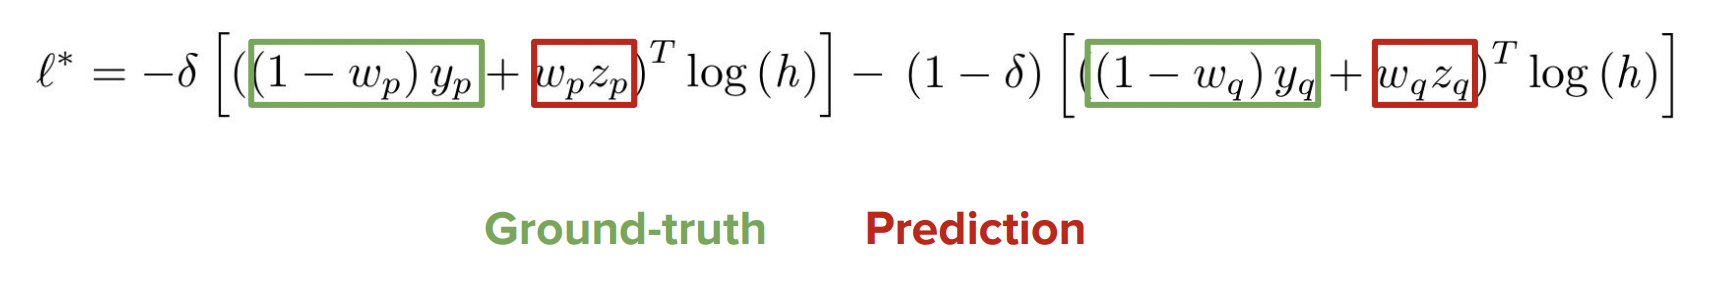

# Testing function

In [ ]:
def testing(args, model, device, test_loader):
    model.eval()
    loss_per_batch = []
    acc_val_per_batch =[]
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            ##Here cross-entropy loss is also estimated, but is split into two parts; log_softmax + negative log likelihood loss
            output = F.log_softmax(output, dim=1)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            loss_per_batch.append(F.nll_loss(output, target).item())
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            acc_val_per_batch.append(100. * correct / ((batch_idx+1)*args.test_batch_size))

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    loss_per_epoch = [np.average(loss_per_batch)]
    acc_val_per_epoch = [np.array(100. * correct / len(test_loader.dataset))]

    return (loss_per_epoch, acc_val_per_epoch)

# Data Transformations
We need to specify a transform here to convert images to torch tensors.

I'm adding a normalization transform here too so that the images have mean zero and unit variance. This is optional. For some problems (models/datasets) proper normalization is important for performance. For others (e.g. models with batch normalization early on), the importance of normalization is less.

In [ ]:
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

## Transformations for training data
transform_train = transforms.Compose([
    transforms.Pad(2, padding_mode='reflect'),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

## Transformations for test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [ ]:
# Create dataset
cifar10_train_val = torchvision.datasets.CIFAR10(args.train_root, train=True, download=True)

trainset = Cifar10Train(args, train=True, transform=transform_train, target_transform=transform_test)
## Add synthetic noise
trainset.random_in_noise()

# Create dataLoaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=0, pin_memory=True)
testset = datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=args.test_batch_size, shuffle=False, num_workers=0, pin_memory=True)

print('-------> Data loading')
print("Training with {0} noise ratio".format(args.noise_ratio))

#Create the CNN
model = SimpleCNN(num_classes = 10).to(device)

print('Total params: %2.fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))

milestones = args.M

##Define optimizer
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=1e-4)
##Define scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

In [ ]:
loss_train_epoch = []
loss_test_epoch = []
acc_train_per_epoch = []
acc_test_per_epoch = []
sample_loss_per_epoch_train = []

sample_loss_per_epoch_tensor = torch.zeros(len(train_loader.dataset)).float().to(device)

res_path = "./metrics_" + args.experiment_name

if not os.path.isdir(res_path):
    os.makedirs(res_path)

np.save(res_path + '/' + 'clean_idx.npy', trainset.clean_indexes)
np.save(res_path + '/' + 'noisy_idx.npy', trainset.noisy_indexes)

cont = 0

for epoch in range(1, args.epoch + 1):

    # One epoch of training
    st = time.time()

    print("Training with " + str(args.noise_ratio) + " noise ratio of uniform random label noise")

    loss_per_epoch, top1_train_ac, sample_loss_per_epoch_tensor = train_mixup_boot(args, model, device, train_loader, optimizer, epoch, sample_loss_per_epoch_tensor)
    scheduler.step()
    loss_train_epoch += [loss_per_epoch]

    # test
    loss_per_epoch_test, acc_val_per_epoch_i = testing(args, model, device, test_loader)

    loss_test_epoch += loss_per_epoch_test
    acc_train_per_epoch += [top1_train_ac]
    acc_test_per_epoch += acc_val_per_epoch_i

    sample_loss_per_epoch_train.append(sample_loss_per_epoch_tensor.cpu().numpy())

    if epoch == 1:
        best_acc_val = acc_val_per_epoch_i[-1]

    else:
        if acc_val_per_epoch_i[-1] > best_acc_val:
            best_acc_val = acc_val_per_epoch_i[-1]

    
    np.save(res_path + '/' + 'LOSS_epoch_train_mixBoot.npy', np.asarray(loss_train_epoch))
    np.save(res_path + '/' + 'LOSS_epoch_val_mixBoot.npy', np.asarray(loss_test_epoch))

    # save accuracies:
    np.save(res_path + '/' + 'accuracy_per_epoch_train_mixBoot.npy', np.asarray(acc_train_per_epoch))
    np.save(res_path + '/' + 'accuracy_per_epoch_val_mixBoot.npy', np.asarray(acc_test_per_epoch))

    # save individual losses per epoch
    np.save(res_path + '/' + 'losses_per_sample_train_mixBoot.npy', np.asarray(sample_loss_per_epoch_train))

    cont += 1

# Accuracy and loss curves

In [ ]:
##Accuracy
acc_train_mixBoot = np.load(res_path + '/' + 'accuracy_per_epoch_train_mixBoot.npy')
acc_test_mixBoot = np.load(res_path + '/' + 'accuracy_per_epoch_val_mixBoot.npy')


#Loss per epoch
loss_train_mixBoot = np.load(res_path + '/' + 'LOSS_epoch_train_mixBoot.npy')
loss_test_mixBoot = np.load(res_path + '/' + 'LOSS_epoch_val_mixBoot.npy')

all_loss_train_epoch_mixBoot = np.load(res_path + '/' + 'losses_per_sample_train_mixBoot.npy')
clean_idx = np.load(res_path + '/' + 'clean_idx.npy')
noisy_idx = np.load(res_path + '/' + 'noisy_idx.npy')

numEpochs = len(acc_test_mixBoot)
epochs = range(numEpochs)

plt.figure(4)
plt.plot(epochs, acc_test_mixBoot, label='Test, max acc: ' + str(np.max(acc_test_mixBoot)))
plt.plot(epochs, acc_train_mixBoot, label='Train, max acc: ' + str(np.max(acc_train_mixBoot)))
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.figure(6)
plt.plot(epochs, np.mean(all_loss_train_epoch_mixBoot[:, np.sort(clean_idx)], 1), label='Clean samples loss')
plt.plot(epochs, np.mean(all_loss_train_epoch_mixBoot[:, np.sort(noisy_idx)], 1), label='Noisy samples loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

**QUESTION FOR STUDENTS**

Explain the loss behaviour. For noisy samples, why the behaviour is different compared to clean samples?

Answer: Since we are using bootstrapping loss correction and mixup data augmentation to prevent memorization, that's why the behaviour is different for noisy samples and clean samples. The noisy samples are relabled to minimize the loss